___

<a href='https://sites.google.com/fat.uerj.br/livia'> <img src='../../figures/capa2.png' /></a>
___

In [1]:
path_data = '../../data/'
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Intervalos de confiança
Desenvolvemos um método para estimar um parâmetro usando amostragem aleatória e bootstrap. Nosso método produz um intervalo de estimativas, para levar em conta a variabilidade aleatória na amostra aleatória. Ao fornecer um intervalo de estimativas em vez de apenas uma estimativa, damos a nós mesmos algum espaço de manobra.

No exemplo anterior vimos que nosso processo de estimação produziu um intervalo bom em cerca de 95% das vezes, sendo um intervalo "bom" aquele que contém o parâmetro. Dizemos que estamos *95% confiantes* de que o processo resulta em um bom intervalo. Nosso intervalo de estimativas é chamado de *intervalo de confiança de 95%* para o parâmetro, e 95% é chamado de *nível de confiança* do intervalo.

O método é chamado de *método do percentil bootstrap* porque o intervalo é formado pela seleção de dois percentis das estimativas bootstrap.

A situação no exemplo anterior foi um pouco incomum. Como sabíamos o valor do parâmetro, pudemos verificar se um intervalo era bom ou ruim e isso, por sua vez, nos ajudou a ver que nosso processo de estimativa capturou o parâmetro cerca de 95 em cada 100 vezes que usamos isto.

Mas geralmente, os cientistas de dados não sabem o valor do parâmetro. Essa é a razão pela qual eles querem estimar isso em primeiro lugar. Em tais situações, eles fornecem um intervalo de estimativas para o parâmetro desconhecido usando métodos como o que desenvolvemos. Por causa da teoria estatística e de demonstrações como a que vimos, os cientistas de dados podem ter certeza de que seu processo de geração do intervalo resulta em um bom intervalo em uma porcentagem conhecida do tempo.

## Estimando uma mediana populacional

Agora usaremos o método bootstrap para estimar uma mediana populacional desconhecida. Você já encontrou o conjunto de dados antes. Provém de uma amostra de recém-nascidos de um grande sistema hospitalar. vamos tratá-lo como se fosse uma amostra aleatória simples, embora a amostragem tenha sido feita em vários estágios. [Stat Labs](https://www.stat.berkeley.edu/~statlabs/) por Deborah Nolan e Terry Speed tem detalhes sobre um conjunto de dados maior do qual este conjunto é extraído.

A tabela 'births' contém as seguintes variáveis para pares mãe-bebê: peso do bebê ao nascer em onças, número de dias gestacionais (o número de dias em que a mãe esteve grávida), idade da mãe em anos completos, altura da mãe em polegadas , peso da gravidez em libras e se a mãe fumou ou não durante a gravidez.

In [2]:
births = pd.read_csv(path_data + 'baby.csv')

In [3]:
births.head()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False


O peso ao nascer é um fator importante na saúde de um recém-nascido. Os bebês menores tendem a precisar de mais cuidados médicos nos primeiros dias do que os recém-nascidos maiores. Portanto, é útil ter uma estimativa do peso ao nascer antes que o bebê nasça. Uma maneira de fazer isso é examinar a relação entre o peso ao nascer e o número de dias gestacionais.

Uma medida simples dessa relação é a razão entre o peso ao nascer e o número de dias gestacionais. A tabela `ratios` contém as duas primeiras colunas de `baby`, bem como uma coluna das proporções. A primeira entrada nessa coluna foi calculada da seguinte forma:

$$
\frac{120~\text{ounces}}{284~\text{days}} ~\approx ~ 0.4225~ \text{ounces per day}
$$

In [8]:
births.loc[:, ['Birth Weight', 'Gestational Days']]

,Birth Weight,Gestational Days
0,120,284
1,113,282
2,128,279
3,108,282
4,136,286
...,...,...
1169,113,275
1170,128,265
1171,130,291
1172,125,281


In [14]:
ratio = births['Birth Weight'] / births['Gestational Days']
ratios = births.loc[:, ['Birth Weight', 'Gestational Days']].assign(Ratio_BW_GD = ratio)
ratios.head()

,Birth Weight,Gestational Days,Ratio_BW_GD
0,120,284,0.422535
1,113,282,0.400709
2,128,279,0.458781
3,108,282,0.382979
4,136,286,0.475524


Here is a histogram of the ratios.

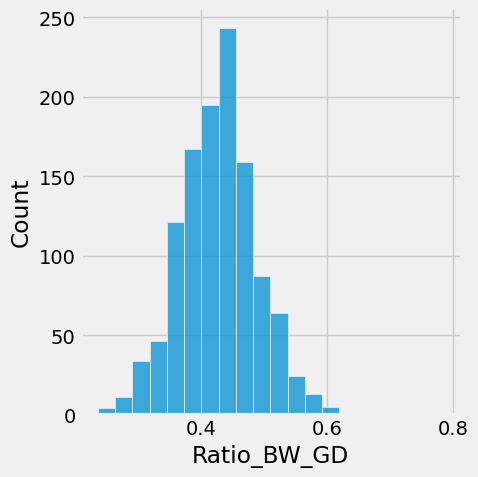

In [21]:
sns.displot(ratios['Ratio_BW_GD'], bins=20);

À primeira vista, o histograma parece bastante simétrico, com a densidade em seu máximo no intervalo de 0,4 onças por dia a 0,45 onças por dia. Mas um olhar mais atento revela que algumas das proporções eram bastante grandes em comparação. O valor máximo das proporções foi de pouco mais de 0,78 onças por dia, quase o dobro do valor típico.

In [22]:
ratios.sort_values('Ratio_BW_GD', ascending=False).head()

,Birth Weight,Gestational Days,Ratio_BW_GD
238,116,148,0.783784
519,174,281,0.619217
1041,174,284,0.612676
819,110,181,0.607735
700,174,288,0.604167


A mediana dá uma noção da proporção típica porque não é afetada pelas proporções muito grandes ou muito pequenas. A proporção média na amostra é de cerca de 0,429 onças por dia.

In [23]:
np.percentile(ratios['Ratio_BW_GD'], 50, method='nearest')

0.42907801418439717

Mas qual era a mediana na população? Não sabemos, então vamos estimar.

Nosso método será exatamente o mesmo da seção anterior. Inicializaremos a amostra 5.000 vezes, resultando em 5.000 estimativas da mediana. Nosso intervalo de confiança de 95% será o "95% intermediário" de todas as nossas estimativas.

### Construindo um Intervalo de Confiança Bootstrap

Começaremos definindo uma função `one_bootstrap_median`. Ele inicializará a amostra e retornará um da proporção mediana na amostra inicializada.

In [28]:
def one_bootstrap_median():
    resample = ratios.sample(frac=1, replace=True)
    return np.percentile(resample['Ratio_BW_GD'], 50, method='nearest')

Execute a célula abaixo para ver como as taxas de bootstrap variam. Lembre-se de que cada um deles é uma estimativa da razão desconhecida (`ratio`) na população.

In [10]:
one_bootstrap_median()

0.43010752688172044

Agora podemos usar um loop `for` para gerar 5000 medianas de bootstrap.

In [31]:
# Generate medians from 5000 bootstrap samples
num_repetitions = 5000
bstrap_medians = np.array([])
for i in np.arange(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())

In [32]:
# Get the endpoints of the 95% confidence interval
left = np.percentile(bstrap_medians, 2.5, method='nearest')
right = np.percentile(bstrap_medians, 97.5, method='nearest')

print(left, right)


0.4254545454545455 0.43272727272727274


O intervalo de confiança de 95% vai de cerca de 0,425 onças por dia para cerca de 0,433 onças por dia. Estamos estimando que a proporção média de "peso ao nascer por dias gestacionais" na população está em algum lugar no intervalo de 0,425 onças por dia a 0,433 onças por dia.

A estimativa de 0,429 com base na amostra original está a meio caminho entre as duas extremidades do intervalo, embora isso não precise ser verdade em geral.

Para visualizar nossos resultados, vamos desenhar o histograma empírico de nossas medianas bootstrap e colocar o intervalo de confiança no eixo horizontal.

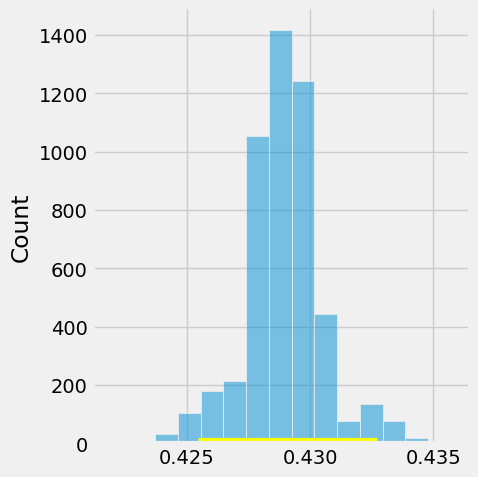

In [36]:
resampled_medians = pd.DataFrame().assign(Bootstrap_Medians=bstrap_medians)
sns.displot(resampled_medians, bins=15, legend=False);
plt.plot([left, right], [0, 0], color='yellow', lw=8);

Este histograma e intervalo se assemelham aos que desenhamos na seção anterior, com uma grande diferença – não há um ponto verde mostrando onde está o parâmetro. Não sabemos onde esse ponto deveria estar, ou mesmo se está no intervalo.

Temos apenas um intervalo de estimativas. É um intervalo de confiança de 95% das estimativas, porque o processo que o gera produz um bom intervalo cerca de 95% das vezes. Isso certamente é melhor do que adivinhar a proporção aleatoriamente!

Lembre-se de que esse intervalo é um intervalo de confiança aproximado de 95%. Existem muitas aproximações envolvidas em seu cálculo. A aproximação não é ruim, mas não é exata.

## Estimando uma média populacional
O que fizemos para as medianas também pode ser feito para as médias. Suponha que queremos estimar a idade média das mães na população. Uma estimativa natural é a idade média das mães da amostra. Aqui está a distribuição de suas idades e sua idade média, que era de cerca de 27,2 anos.

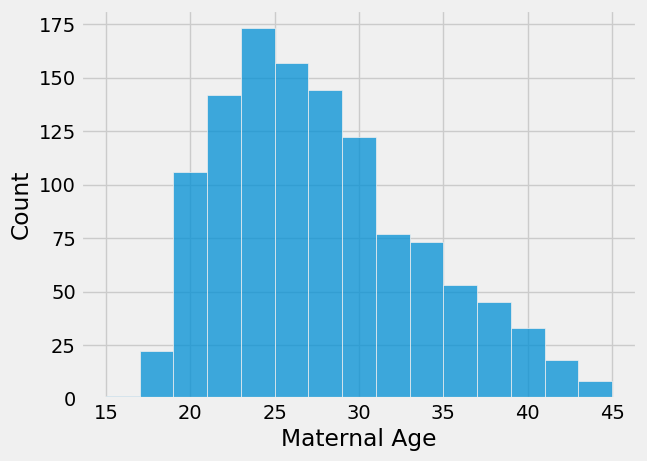

In [40]:
sns.histplot(births['Maternal Age'], bins=15);

In [41]:
np.average(births['Maternal Age'])

27.228279386712096

Qual era a idade média das mães na população? Não sabemos o valor deste parâmetro.

Vamos estimar o parâmetro desconhecido pelo método bootstrap. Para fazer isso, vamos adaptar o código de `bootstrap_median` para definir a função `bootstrap_mean`. O código é o mesmo, exceto que as estatísticas são médias (ou seja, médias) em vez de medianas, e são coletadas em uma matriz chamada `bstrap_means` em vez de `bstrap_medians`.

In [42]:
def one_bootstrap_mean():
    resample = births.sample(frac=1, replace=True)
    return np.average(resample['Maternal Age'])

In [43]:
# Generate means from 5000 bootstrap samples
num_repetitions = 5000
bstrap_means = np.array([])
for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean())

In [44]:
# Get the endpoints of the 95% confidence interval
left = np.percentile(bstrap_means, 2.5, method='nearest')
right = np.percentile(bstrap_means, 97.5, method='nearest')

print(left, right)


26.890971039182283 27.563032367972742


O intervalo de confiança de 95% vai de cerca de 26,9 anos para cerca de 27,6 anos. Ou seja, estamos estimando que a idade média das mães na população esteja em algum lugar no intervalo de 26,9 anos a 27,6 anos.

Observe como as duas extremidades estão próximas da média de cerca de 27,2 anos na amostra original. O tamanho da amostra é muito grande – 1.174 mães – e, portanto, as médias das amostras não variam muito. Exploraremos mais essa observação no próximo capítulo.

O histograma empírico das 5.000 idades médias de bootstrap é mostrado abaixo, juntamente com o intervalo de confiança de 95% para a idade média da população.

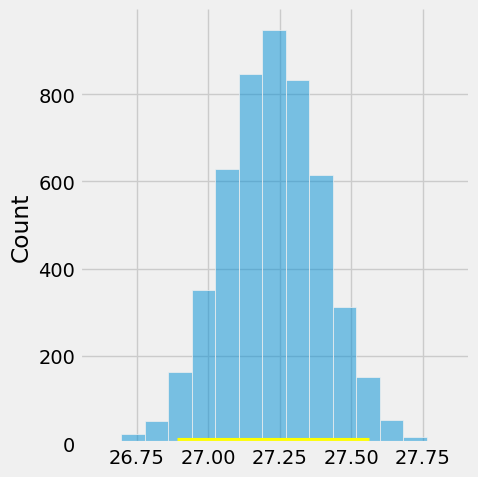

In [46]:
resampled_means = pd.DataFrame().assign(Bootstrap_Mean=bstrap_means)
sns.displot(resampled_means, bins=15, legend=False);
plt.plot([left, right], [0, 0], color='yellow', lw=8);

Mais uma vez, a média da amostra original (27,23 anos) está próxima do centro do intervalo. Isso não é muito surpreendente, porque cada amostra inicializada é extraída da mesma amostra original. As médias das amostras bootstrap são distribuídas simetricamente em ambos os lados da média da amostra da qual foram extraídas.

Observe também que o histograma empírico das médias reamostradas tem aproximadamente uma forma de sino simétrica, embora o histograma das idades amostradas não seja simétrico:

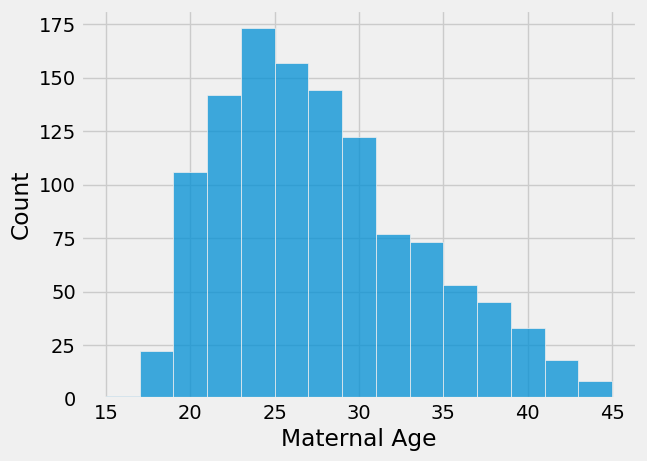

In [48]:
sns.histplot(births['Maternal Age'], bins=15);

Esta é uma consequência do `Teorema do Limite Central` de probabilidade e estatística. Em seções posteriores, veremos o que diz o teorema.

## Um intervalo de confiança de 80%
Você pode usar os meios de amostra bootstrap para construir um intervalo de qualquer nível de confiança. Por exemplo, para construir um intervalo de confiança de 80% para a idade média da população, você usaria os "80% intermediários" das médias reamostradas. Portanto, você desejaria 10% da distribuição em cada uma das duas caudas e, portanto, os pontos finais seriam os percentis 10 e 90 das médias reamostradas.

In [49]:
left_80 = np.percentile(bstrap_means, 10, method='nearest')
right_80 = np.percentile(bstrap_means, 90, method='nearest')

print(left_80, right_80)

27.01022146507666 27.4412265758092


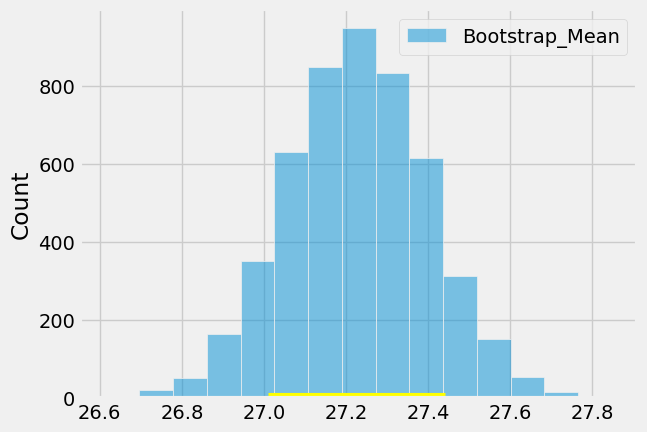

In [50]:
sns.histplot(resampled_means, bins=15);
plt.plot([left_80, right_80], [0, 0], color='yellow', lw=8);

Este intervalo de confiança de 80% é muito mais curto do que o intervalo de confiança de 95%. Só vai de cerca de 27,0 anos para cerca de 27,4 anos. Embora seja um conjunto restrito de estimativas, você sabe que esse processo só produz um bom intervalo cerca de 80% do tempo.

O processo anterior produziu um intervalo mais amplo, mas tínhamos mais confiança no processo que o gerou.

Para obter um intervalo de confiança estreito em um alto nível de confiança, você terá que começar com uma amostra maior. Veremos por que no próximo capítulo.

## Estimando uma Proporção da População
Na amostra, 39% das mães fumaram durante a gravidez.

In [52]:
births[births["Maternal Smoker"] == True].shape[0] / births.shape[0]

0.3909710391822828

Lembre-se de que uma proporção é uma média de zeros e uns. Portanto, a proporção de mães que fumam também pode ser calculada usando operações de matriz como segue.

In [54]:
smoking = births["Maternal Smoker"]
np.count_nonzero(smoking)/len(smoking)

0.3909710391822828

Que porcentagem de mães na população fumou durante a gravidez? Este é um parâmetro desconhecido que podemos estimar por um intervalo de confiança bootstrap. As etapas são análogas àquelas que adotamos para estimar a mediana e a média da população.

Em um processo que agora é familiar, iniciaremos definindo uma função `one_bootstrap_proportion` que inicializa a amostra e retorna a proporção de fumantes na amostra inicializada. Em seguida, chamaremos a função várias vezes usando um loop `for` e obteremos o 2,5º perentil e o 97,5º percentis das proporções de bootstrap.

In [55]:
def one_bootstrap_proportion():
    resample = births.sample(frac=1, replace=True)
    smoking = resample["Maternal Smoker"]
    return np.count_nonzero(smoking)/len(smoking)


In [56]:
# Generate proportions from 5000 bootstrap samples
bstrap_proportions = np.array([])
num_repetitions = 5000
for i in np.arange(num_repetitions):
    bstrap_proportions = np.append(bstrap_proportions, one_bootstrap_proportion())

In [57]:
# Get the endpoints of the 95% confidence interval
left = np.percentile(bstrap_proportions, 2.5, method='nearest')
right = np.percentile(bstrap_proportions, 97.5, method='nearest')

print(left, right)


0.3628620102214651 0.4182282793867121


O intervalo de confiança vai de cerca de 36% a cerca de 42%.

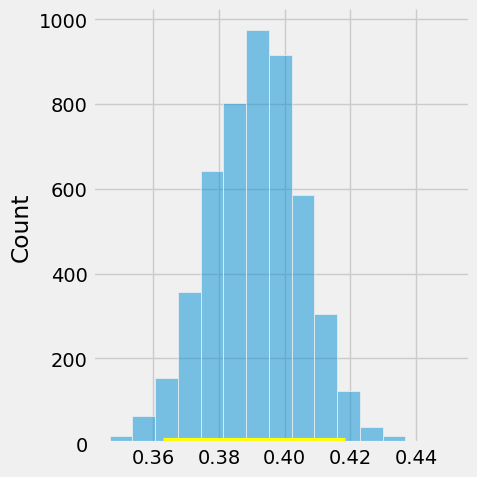

In [58]:
resampled_proportions = pd.DataFrame().assign(Bootstrap_Proportions=bstrap_proportions)
sns.displot(resampled_proportions, bins=15, legend=False);
plt.plot([left, right], [0, 0], color='yellow', lw=8);

## Cuidados ao Usar o Método de Percentil Bootstrap
O bootstrap é um método elegante e poderoso. Antes de usá-lo, é importante ter alguns pontos em mente.

- Comece com uma grande amostra aleatória. Caso contrário, o método pode não funcionar. Seu sucesso é baseado em grandes amostras aleatórias (e, portanto, também reamostras da amostra) semelhantes à população. A Lei das Médias diz que isso provavelmente será verdade, desde que a amostra aleatória seja grande.

- Para aproximar a distribuição de probabilidade de uma estatística, é uma boa ideia replicar o procedimento de reamostragem tantas vezes quanto possível. Alguns milhares de replicações resultarão em aproximações decentes para a distribuição da mediana da amostra, especialmente se a distribuição da população tiver um pico e for bastante simétrica. Usamos 5.000 replicações em nossos exemplos, mas recomendamos 10.000 em geral.

- O método de percentil bootstrap funciona bem para estimar a mediana ou média populacional com base em uma grande amostra aleatória. No entanto, tem limitações, assim como todos os métodos de estimativa. Por exemplo, *não* é esperado que ele tenha um bom desempenho nas seguintes situações.
     - O objetivo é estimar o valor mínimo ou máximo na população, ou um percentil muito baixo ou muito alto, ou parâmetros muito influenciados por elementos raros da população.
     - A distribuição de probabilidade da estatística não é grosseiramente em forma de sino.
     - A amostra original é muito pequena, digamos menos de 10 ou 15.